# Modeling & Evaluation

Nachdem die Daten einer optimalen Vorbereitung unterzogen wurden, erfolgt nun die Berechnung, Evaluation und Optimierung der Modelle. Hierbei kommen geeignete Modellierungsverfahren zum Einsatz, die den Anforderungen des Forschungsprojekts gerecht werden. Nachdem die Modelle berechnet wurden, erfolgt eine gründliche Evaluation ihrer Leistungen. Hierbei werden verschiedene Evaluationsmetriken herangezogen, um die Vorhersagegenauigkeit, Robustheit und andere relevante Aspekte zu bewerten. Auf Basis der Evaluationsergebnisse werden die Modelle weiter optimiert, um ihre Leistung zu verbessern.

#### Inhalt

- [Topic Modeling](#topic_modeling)
- [Time Series Forecasting](#time_series_forecasting)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Topic Modeling <a name="topic_modeling"></a>

### Modeling

#### 🧩 Modeling ☕

Der folgende Code importiert eigens speziell entwickelte Klassen und Methoden, die für das LDA-Topic-Modeling optimiert sind. Es wird empfohlen, diese Methode zur Erstellung der Modelle zu verwenden. Eine ausführlichere Darstellung des Codes befindet sich in der Datei `src/models/topic_modeling.py`

In [1]:
from src.models import topic_modeling as tm
from src.utils import safe_as_pkl
import pandas as pd

# load dataframe
df = pd.read_feather('../data/processed/twitter_tweets_processed.feather')

# create & build lda model
lda_model = tm.LdaModel(text=df['preprocessed_text'])
lda_model.build(num_topics=11)

# export
safe_as_pkl(lda_model, path='../models/lda_model.pkl')

960217

#### Ergebnisse visualisieren ☕

In [ ]:
import pyLDAvis.gensim_models
from src.utils import load_pkl

lda_model = load_pkl('../models/lda_model.pkl')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model.model, lda_model.corpus, lda_model.dictionary, sort_topics=False)
vis

### Evaluation

#### 1. Coherence Score berechnen ☕

Der Coherence Score ist ein Evaluationsmaß für Topic Models, das versucht, die Kohärenz der gefundenen Themen zu bewerten. Die Kohärenz bezieht sich darauf, wie gut die Wörter innerhalb eines Themas zusammenpassen und ob sie eine sinnvolle Bedeutung ergeben. Ein hohes Maß an Kohärenz zeigt an, dass die Themen gut definiert und interpretierbar sind.

In [ ]:
from src.models import topic_modeling as tm
from src.utils import load_pkl

lda_model = load_pkl('../models/lda_model.pkl')
coherence_score = tm.evaluate(model=lda_model.model, text=lda_model.text, dictionary=lda_model.dictionary)

#### 2. Hyperparameter Tuning durchführen 🌒

Hyperparameter Tuning ist ein wichtiger Schritt im Machine Learning, der dazu beiträgt, das bestmögliche Modell zu finden. In diesem Fall wird das bestmögliche Modell anhand des Coherence Scores bemessen. Ziel des Hyperparameter Tuning ist es demnach, das Modell mit dem höchsten Coherence Score zu finden. Folgende Parameter sollen optimiert werden:

`num_topics`, `alpha`, `eta`, `chunksize`, `iterations`, `passes`

*Wertebereiche für Hyperparameter festlegen*

In [ ]:
from hyperopt import hp

search_space = {
    'num_topics': hp.choice('num_topics', [i for i in range(12, 28)]),
    'alpha': hp.choice('alpha', ['symmetric', 'asymmetric', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'eta': hp.choice('eta', ['symmetric', 'auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'chunksize':  hp.choice('chunksize', [5000]),
    'iterations': hp.choice('iterations', [50, 100]),
    'passes': hp.choice('passes', [8, 9, 10])
}

*Bayesian Optimization durchführen* ⭕️

Die bayesianische Optimierung ist ein Ansatz zur Suche nach den optimalen Parametereinstellungen eines Modells durch die Kombination von Modellierung der Zielfunktion mittels einer Wahrscheinlichkeitsverteilung und adaptiver Exploration des Suchraums.

*Hinweis: Um die erforderlichen Berechnungen erfolgreich durchzuführen, ist eine leistungsstarke Computerumgebung erforderlich. Die nachfolgenden Berechnungen wurden auf einem virtuellen Server mit den folgenden Spezifikationen durchgeführt*

- *Virtualisierungstechnik: KVM*
- *Prozessor: 18 vCores*
- *RAM: 48GB DDR4 ECC*

In [ ]:
%%script false
from src.models.bayesian_optimization import optimize_topic_modeling

df, optimized_parameters = optimize_topic_modeling('../data/processed/twitter_tweets_processed.feather',search_space, 200)

*Hyperparameter Tuning auswerten*

In [1]:
import pandas as pd

df = pd.read_feather('../data/modeling/tm_ht_results.feather')
df.sort_values('coherence_score', ascending=False, inplace=True)
df.head(10)

,seed,num_topics,alpha,eta,chunksize,iterations,passes,coherence_score
174,1688143687,20,asymmetric,0.3,5000,100,10,0.574427
146,1688126978,20,0.2,0.8,5000,100,10,0.565932
59,1688078979,18,asymmetric,0.6,5000,100,8,0.543286
111,1688106679,20,asymmetric,0.3,5000,100,10,0.542387
96,1688097981,12,asymmetric,0.7,5000,100,10,0.539939
49,1688072932,20,0.2,0.8,5000,100,10,0.538800
62,1688080409,18,asymmetric,0.6,5000,100,8,0.536490
100,1688100083,12,0.2,0.7,5000,50,10,0.533993
145,1688126325,20,0.2,0.8,5000,100,10,0.531398
60,1688079423,18,asymmetric,0.6,5000,100,8,0.530991


#### 3. Erstellen optimiertes LDA-Modell ⭕️☕

Nach der Ausführung des Hyperparameter-Tunings, kann eine gute Auswahl von Hyperparametern getroffen werden. Mithilfe der optimierten Parameter kann im folgenden das optimierte LDA-Modell erstellt und berechnet werden.

In [7]:
%%script false
from src.models import topic_modeling as tm
from src.utils import safe_as_pkl
import pandas as pd

# load dataframe
df = pd.read_feather('../data/processed/twitter_tweets_processed.feather')

# create & build optimized lda model
lda_model = tm.LdaMulticoreModel(text=df['preprocessed_text'])
lda_model.build(
    
    seed=1688078979, 
    num_topics=18, 
    alpha='asymmetric', 
    eta=0.6,
    chunksize=5000,
    iterations=100,
    passes=8

)

# export
safe_as_pkl(lda_model, path='../models/optimized_lda_model_174.pkl')

2023-07-02 10:19:51,015 - INFO - Initialize model; create dictionary and corpus...
2023-07-02 10:20:47,950 - INFO - enable multiprocessing...
2023-07-02 10:20:52,202 - INFO - calculate lda model...
2023-07-02 10:40:08,116 - INFO - Done. Model calculated successfully!


#### 4. Ergebnisse visualisieren ☕

In [9]:
import pyLDAvis.gensim_models
from src.utils import load_pkl

# load optimized lda model
lda_model = load_pkl('../models/optimized_lda_model_174.pkl')

# visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model.model, lda_model.corpus, lda_model.dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.363554  0.054912       1        1  24.695724
0     -0.307673  0.074208       2        1  18.520189
2     -0.298656  0.189352       3        1  17.050462
9     -0.230131 -0.241731       4        1   8.729160
3     -0.192433 -0.050376       5        1   6.036593
4     -0.182004  0.046917       6        1   5.866192
6     -0.083943 -0.093880       7        1   3.731598
12    -0.010596  0.023926       8        1   3.018623
17    -0.054903 -0.168212       9        1   2.970228
11     0.106851 -0.023960      10        1   1.692985
5      0.100236  0.027760      11        1   1.445473
8      0.139236  0.036536      12        1   1.272835
18     0.140183  0.026088      13        1   1.148184
7      0.152733  0.024999      14        1   0.919475
13     0.175669  0.021451      15        1   0.730517
10     0.180200  0.011941      16        1   0.628084
16     0.162690  0.021767      17        1   0.599629
15     0.188855  0.005856      18        1   0.338136
14     0.188453  0.006904      19        1   0.328979
19     0.188788  0.005542      20        1   0.276934, topic_info=             Term           Freq          Total Category  logprob  loglift
57             ai  138222.000000  138222.000000  Default  30.0000  30.0000
12        startup   59865.000000   59865.000000  Default  29.0000  29.0000
14           tech  413616.000000  413616.000000  Default  28.0000  28.0000
81           data   66294.000000   66294.000000  Default  27.0000  27.0000
15     technology  413457.000000  413457.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
64396    ucalgary      34.239336      38.308994  Topic20  -7.2027   5.7768
52377    kimberly      29.847641      33.917030  Topic20  -7.3400   5.7613
34897    benjamin      32.318760      37.124574  Topic20  -7.2605   5.7505
11225      dealer      48.155371      86.659575  Topic20  -6.8617   5.3016
3391        movie      64.641772    2373.842703  Topic20  -6.5673   2.2857

[1065 rows x 6 columns], token_table=        Topic      Freq Term
term                        
826         7  0.997466   ":
13343      17  0.990889   **
5099        9  0.997885   ,#
3064       11  0.995623   -&
5134       11  0.993661  --&
...       ...       ...  ...
254636      4  0.002603  °°°
254636     11  0.989267  °°°
52579      17  0.965355  ⁦⁦⁩
46801      17  0.998716   ⁦⁩
4360        1  0.997273   ️⃣

[2349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 10, 4, 5, 7, 13, 18, 12, 6, 9, 19, 8, 14, 11, 17, 16, 15, 20])

---

## Time Series Forecasting <a name="time_series_forecasting"></a>

### Data Preparation

Im Rahmen der Berechnung der Time Series Forecasting Modelle ist es notwendig, die Daten einer Transformation zu unterziehen. Dieser Transformationsprozess beinhaltet zunächst die Zuordnung der Tweets zu den zuvor identifizierten Topics. Dadurch entsteht ein neuer Datensatz, der nach den Topics gruppiert wird. Für jedes Topic wird daraufhin eine spezifische Zeitreihe erstellt. Die Erstellung der Zeitreihen erfolgt durch Zählen der Anzahl von Tweets pro Tag, die einem bestimmten Topic zugeordnet werden können. Diese Vorgehensweise ermöglicht es, die zeitliche Entwicklung der Tweets zu analysieren und die relevanten Informationen für die einzelnen Topics zu erfassen.

#### 1. Topic Zuordnung ☕

In [59]:
%%script false
from src.utils import load_pkl, tweet_topic_assignment
import pandas as pd

lda_model = load_pkl('../models/optimized_lda_model_174.pkl')
df = pd.read_feather('../data/processed/twitter_tweets_processed.feather')

df['topics'] = tweet_topic_assignment(lda_model, topic_minimum_probability=0.20)
df.to_feather('../data/modeling/topic_assigned_twitter_tweets.feather')

df.head(5)

Couldn't find program: 'false'


#### 2. Topic Time Series erstellen

In [60]:
from src.models.time_series_forecasting import process_to_timeseries
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

df_topics_assigned = pd.read_feather('../data/modeling/topic_assigned_twitter_tweets.feather')
df_topic_grouped_ts = process_to_timeseries(df_topics_assigned)

# define min max scaler
scaler = MinMaxScaler(feature_range=(0, 100))

list_topic_time_series = []
for topic, df in df_topic_grouped_ts:
    df.drop('topic', axis=1, inplace=True)

    # normalize data and convert the normalized data back into a DataFrame
    normalized_data = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_data, index=df.index, columns=df.columns)
    
    ttsd = {'id': (topic+1), 'label': None, 'data': normalized_df}

    list_topic_time_series.append(ttsd)

2023-07-06 23:37:03,216 - WARNING - 62 tweets could not be assigned to a topic! -> Drop...


#### 3. Labeling

*Hinweis: Es ist zu beachten, dass alle nicht gelabelten Topics im Datenbestand aussortiert werden und für die weiteren Modellierungsprozesse nicht weiter berücksichtigt werden.*

In [61]:
topic_labels = {
    4: 'Blockchain-Technologie',
    10: 'Künstliche Intelligenz',
    12: 'VR, AR und Metaverse',
    18: 'Cybersicherheit'
}

In [62]:
from src.models.time_series_forecasting import XGBoostModel2
from src.utils import safe_as_pkl

for ttsd in list_topic_time_series:
    if ttsd['id'] in topic_labels:
        xgb_model = XGBoostModel2(id=ttsd['id'], timeseries=ttsd['data'])
        xgb_model.label = topic_labels[ttsd['id']]
        safe_as_pkl(xgb_model, f"../models/xgb_model_{ttsd['id']}.pkl")

#### 4. Aufteilung in Trainings- und Testdaten

In [63]:
from src.models.time_series_forecasting import XGBoostModel2
from src.utils import load_pkl, safe_as_pkl

xgb_models = [
    load_pkl('../models/xgb_model_4.pkl'),
    load_pkl('../models/xgb_model_10.pkl'),
    load_pkl('../models/xgb_model_12.pkl'),
    load_pkl('../models/xgb_model_18.pkl')
]

for model in xgb_models:
    data_train, data_test = XGBoostModel2.train_test_split(data=model.timeseries, train_size=0.9)
    model.data_train = data_train
    model.data_test = data_test
    safe_as_pkl(model, f"../models/xgb_model_{model.id}.pkl")

### Feature Engineering

Feature Engineering bezeichnet den Prozess der Erzeugung neuer Merkmale oder der Transformation vorhandener Merkmale, um die Leistung von Modellen in maschinellem Lernen zu verbessern. Das Feature Engineering ermöglicht es dem XGBoost-Modell daher, ein umfassenderes Verständnis der Daten zu entwickeln und eine verbesserte Vorhersageleistung zu erzielen. Indem relevante Informationen in den Merkmalen gezielt hervorgehoben oder hinzugefügt werden, können nicht-lineare Zusammenhänge besser erfasst und die Fähigkeit des Modells zur Generalisierung gesteigert werden.

```
['day'] = data.index.day
['week'] = data.index.isocalendar().week.astype(int)
['month'] = data.index.month
['weekday'] = data.index.weekday
```

### Modeling

In [64]:
from src.models.time_series_forecasting import XGBoostModel2
from src.utils import load_pkl, safe_as_pkl

xgb_models = [
    load_pkl('../models/xgb_model_4.pkl'),
    load_pkl('../models/xgb_model_10.pkl'),
    load_pkl('../models/xgb_model_12.pkl'),
    load_pkl('../models/xgb_model_18.pkl')
]

for model in xgb_models:
    model.build(**{'n_estimators': 1000})
    safe_as_pkl(model, f"../models/xgb_model_{model.id}.pkl")

### Evaluation

#### 1. Hyperparameter Tuning durchführen 🎬

Auch für die XGBoost Modelle ist es von Bedeutung ein Hyperparameter Tuning durchzuführen, um die Genauigkeit der Modelle zu verbessern. Hierbei wird das bestmögliche Modell anhand der Evaluationsmetrik des Mean Absolute Error (MAE) beurteilt. Das Ziel des Hyperparameter Tunings besteht darin, jene Modelle zu ermitteln, das den geringsten durchschnittlichen absoluten Fehler aufweist. Folgende Parameter sollen optimiert werden:

`n_estimators`, `learning_rate`, `max_depth`

*Wertebereiche für Hyperparameter festlegen*

In [65]:
from hyperopt import hp
import numpy as np

search_space = {
    'n_estimators': hp.choice('n_estimators', [100, 500, 1000, 1200, 1400, 1600, 1800, 2000, 4000]),
    'learning_rate': hp.choice('learning_rate', np.arange(0.01, 0.4, 0.01).tolist()), 
    'max_depth': hp.choice('max_depth', [i for i in range(5, 73)])        
}

*Bayesian Optimization durchführen*

In [66]:
from src.models.time_series_forecasting import XGBoostModel2
from src.models.bayesian_optimization import optimize_xgb_modeling
from src.utils import safe_as_pkl

xgb_models = [
    load_pkl('../models/xgb_model_4.pkl'),
    load_pkl('../models/xgb_model_10.pkl'),
    load_pkl('../models/xgb_model_12.pkl'),
    load_pkl('../models/xgb_model_18.pkl')
]

for model in xgb_models:
    optimized_parameters = optimize_xgb_modeling(model, search_space, 300)
    model.build(**optimized_parameters)
    safe_as_pkl(model, f"../models/xgb_model_{model.id}.pkl")

2023-07-06 23:37:40,468 - INFO - Start bayesian optimization algorithm for XGB-Model: Blockchain-Technologie


100%|██████████████████████████████████████████████| 300/300 [16:54<00:00,  3.38s/trial, best loss: 15.362651332326736]

2023-07-06 23:54:34,730 - INFO - Done. Optimized parameters: {'learning_rate': 0.14, 'max_depth': 39, 'n_estimators': 1800}


2023-07-06 23:54:37,878 - INFO - Start bayesian optimization algorithm for XGB-Model: Künstliche Intelligenz


100%|██████████████████████████████████████████████| 300/300 [14:32<00:00,  2.91s/trial, best loss: 14.350404863401582]

2023-07-07 00:09:10,840 - INFO - Done. Optimized parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


2023-07-07 00:09:11,012 - INFO - Start bayesian optimization algorithm for XGB-Model: VR, AR und Metaverse


100%|███████████████████████████████████████████████| 300/300 [16:07<00:00,  3.22s/trial, best loss: 6.629870264445707]

2023-07-07 00:25:18,674 - INFO - Done. Optimized parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}


2023-07-07 00:25:18,865 - INFO - Start bayesian optimization algorithm for XGB-Model: Cybersicherheit


100%|██████████████████████████████████████████████| 300/300 [12:51<00:00,  2.57s/trial, best loss: 13.389966691802135]

2023-07-07 00:38:10,554 - INFO - Done. Optimized parameters: {'learning_rate': 0.060000000000000005, 'max_depth': 5, 'n_estimators': 100}


#### 2. Ergebnisse visualisieren

Blockchain-Technologie
Average value of the dependent variable (AVG): 44.7043
Mean Absolute Error (MAE): 15.362651332326736
Mean Absolute Percentage Error (MAPE): 0.3333123669813533
Root Mean Squared Error (RMSE): 18.80464375731112



Künstliche Intelligenz
Average value of the dependent variable (AVG): 62.7102
Mean Absolute Error (MAE): 14.350404863401582
Mean Absolute Percentage Error (MAPE): 0.2156046989527972
Root Mean Squared Error (RMSE): 18.535889122749243



VR, AR und Metaverse
Average value of the dependent variable (AVG): 18.165
Mean Absolute Error (MAE): 6.629870264445707
Mean Absolute Percentage Error (MAPE): 362647323870258.7
Root Mean Squared Error (RMSE): 9.224638031089235



Cybersicherheit
Average value of the dependent variable (AVG): 48.3404
Mean Absolute Error (MAE): 13.389966691802135
Mean Absolute Percentage Error (MAPE): 0.26817630832914024
Root Mean Squared Error (RMSE): 17.55032882650518





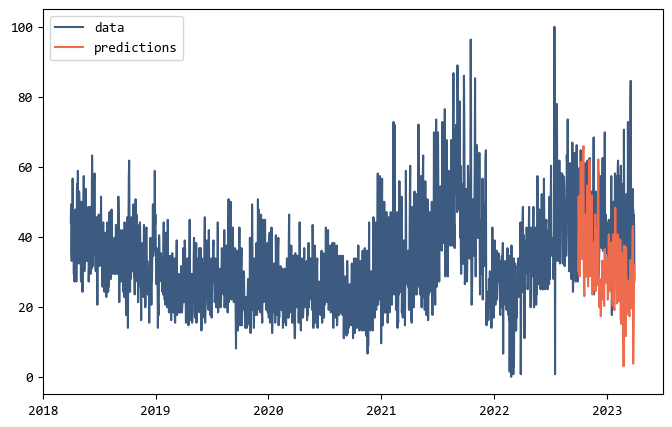

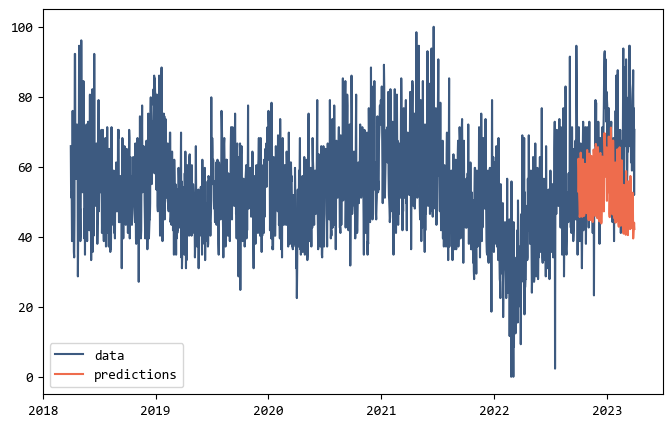

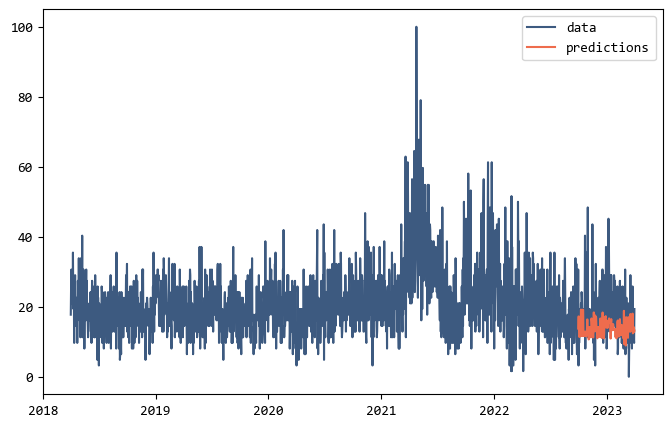

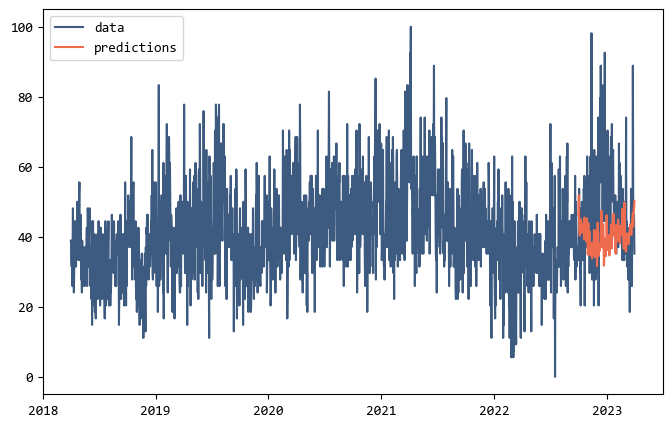

In [67]:
from src.models.time_series_forecasting import XGBoostModel2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from src.utils import load_pkl
import pandas as pd

xgb_models = [
    load_pkl('../models/xgb_model_4.pkl'),
    load_pkl('../models/xgb_model_10.pkl'),
    load_pkl('../models/xgb_model_12.pkl'),
    load_pkl('../models/xgb_model_18.pkl')
]

for model in xgb_models:
    data_test_assigned_predictions = model.data_test.assign(predictions=model.predictions)
    _ = pd.concat([model.data_train, data_test_assigned_predictions])

    plt.rcParams['font.family'] = 'Consolas'
    plt.figure(figsize=(8, 5)) # width, height
    plt.plot(_['count'], label='data', color='#3d5a80')
    plt.plot(_['predictions'], label='predictions', color='#ee6c4d')
    plt.legend()
    plt.savefig(f'../export/xgb_lchart_{model.id}.svg', format='svg')
    
    avg = model.data_test['count'].mean()
    mae = model.evaluate()
    mape = mean_absolute_percentage_error(model.data_test['count'], data_test_assigned_predictions['predictions'])
    rmse = mean_squared_error(model.data_test['count'], data_test_assigned_predictions['predictions'], squared=False)
    
    print(model.label)
    print(f'Average value of the dependent variable (AVG): {round(avg, 4)}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    
    print('\n\n')

---